<a href="https://colab.research.google.com/github/memukesh18/EEG_SIGNAL-ANALYSIS/blob/main/EEG_Signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**


In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.1 MB/s eta 0:00:00


In [ ]:
import mne
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from tqdm import tqdm

**Chech for GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load BrainVision EEG Data
**Loading EEG data**

In [ ]:
# Load EEG data
vhdr_file = "OCD/aap0308_OCD_pure_opened_closed_eyes.vhdr"
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

# Set channel types
#raw.set_channel_types({'blood_pressure': 'bio', 'GSR': 'bio'})
raw.set_channel_types({ch: 'eeg' for ch in raw.ch_names if ch.startswith('EEG')})

Extracting parameters from OCD/aap0308_OCD_pure_opened_closed_eyes.vhdr...
Setting channel info structure...


<ipython-input-7-21605a649b98>:3: RuntimeWarning: No coordinate information found for channels ['blood_pressure', 'GSR']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)


Reading 0 ... 1526999  =      0.000 ...  3053.998 secs...


<ipython-input-7-21605a649b98>:3: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['blood_pressure', 'GSR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)


<RawBrainVision | aap0308_OCD_pure_opened_closed_eyes.eeg, 65 x 1527000 (3054.0 s), ~757.3 MiB, data loaded>

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG, 2 misc
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 500.0 Hz
>
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'blood_pressure', 'GSR']
Using matplotlib as 2D backend.


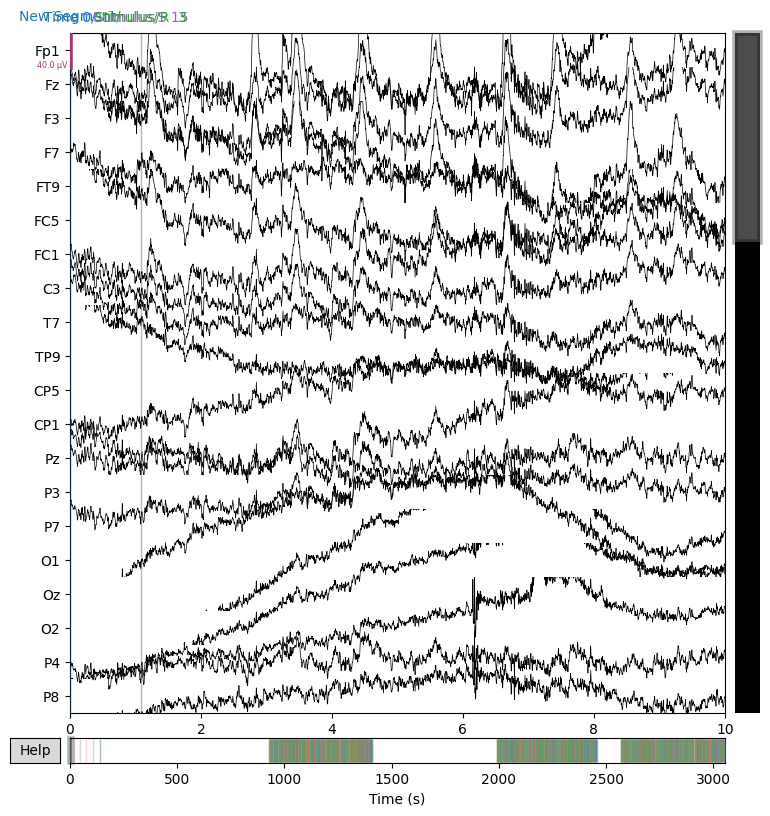

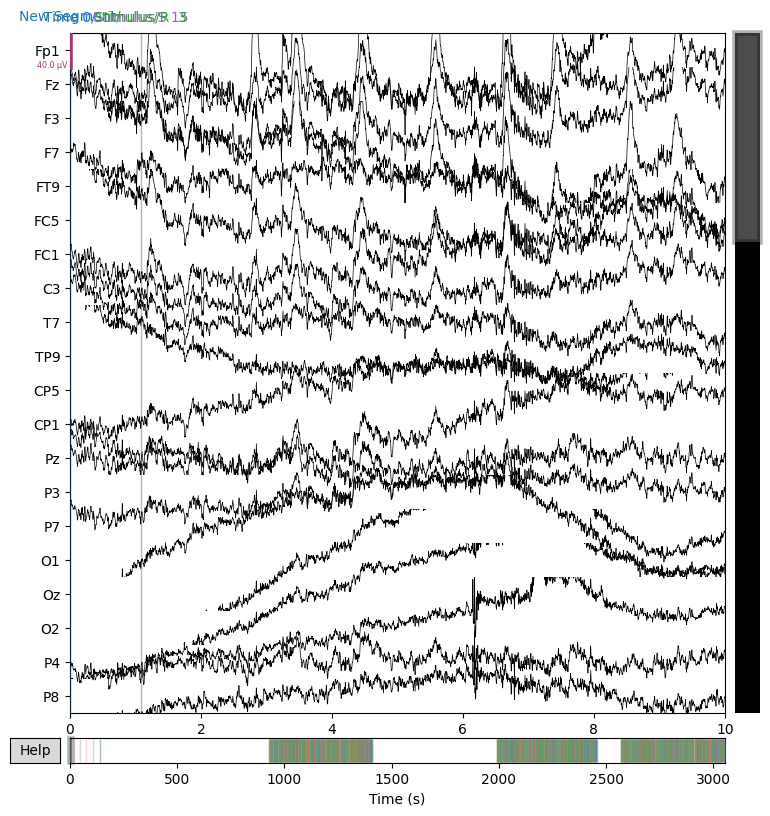

In [ ]:
print(raw.info)
print(raw.info['ch_names'])
raw.plot()

In [ ]:
raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


<RawBrainVision | aap0308_OCD_pure_opened_closed_eyes.eeg, 65 x 1527000 (3054.0 s), ~757.3 MiB, data loaded>

**b) Re-referencing**

**Set the average reference or a specific reference electrode:**

In [ ]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | aap0308_OCD_pure_opened_closed_eyes.eeg, 65 x 1527000 (3054.0 s), ~757.3 MiB, data loaded>

# Event Detection & Epoching
**If your EEG data includes event markers, extract them:**

In [ ]:
# Extract events
events, event_id = mne.events_from_annotations(raw)

# Define epochs (e.g., from -0.2s to 0.8s relative to an event)
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.8, baseline=(None, 0), preload=True, event_repeated='merge')


Used Annotations descriptions: ['New Segment/', 'Stimulus/R  1', 'Stimulus/R  3', 'Stimulus/R  4', 'Stimulus/S  1', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 27', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 37', 'Time 0/']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
1814 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1814 events and 501 original time points ...
1 bad epochs dropped


In [ ]:
print(epochs.info['ch_names'])
print(events[:10])

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'blood_pressure', 'GSR']
[[    0     0 99999]
 [    0     0 10004]
 [  543     0    15]
 [  543     0 10002]
 [ 8206     0     6]
 [23232     0     7]
 [38251     0     6]
 [53271     0     7]
 [68802     0    15]
 [68802     0 10002]]


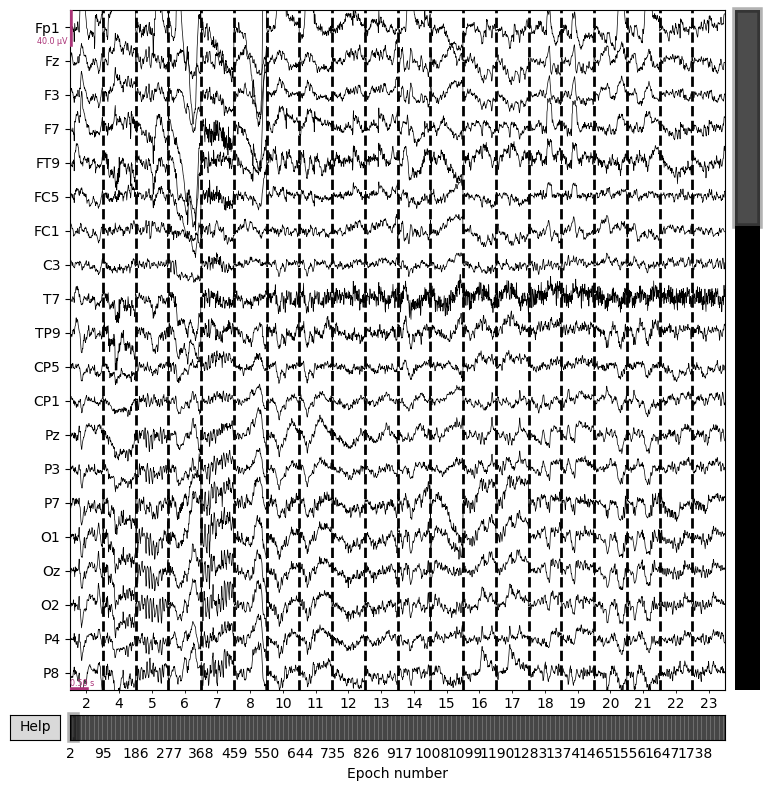

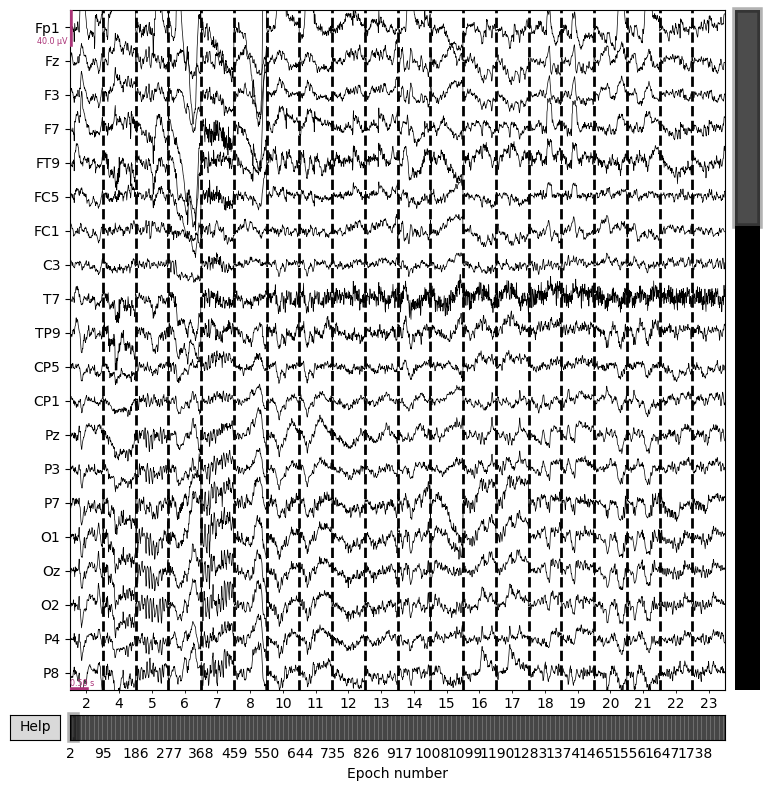

In [ ]:
epochs.plot()

# Power Spectral Analysis
**power spectral density (PSD):**

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


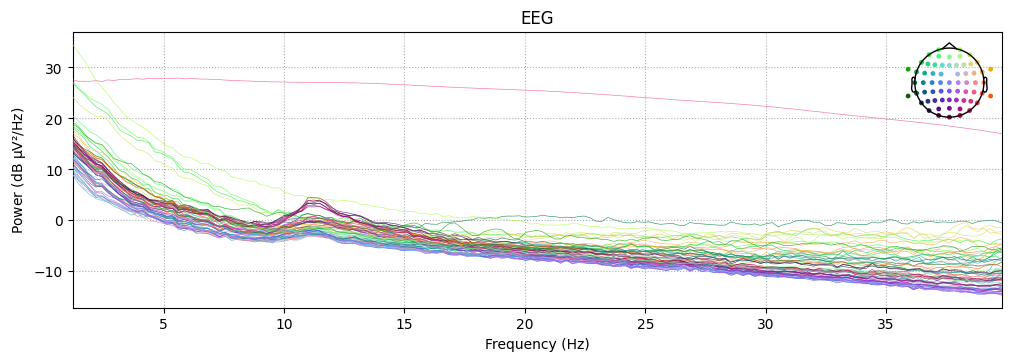

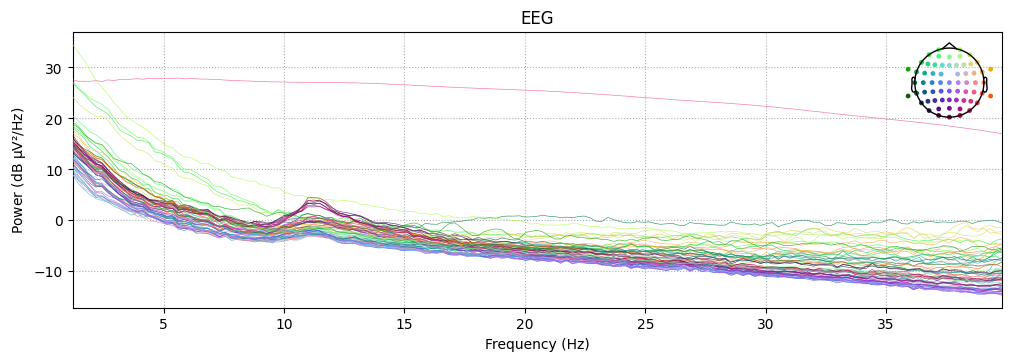

In [ ]:
#raw.plot_psd(fmin=1, fmax=40)
raw.compute_psd(fmin=1, fmax=40).plot()

# Time-Frequency Analysis
**Morlet wavelets**

In [ ]:
frequencies = np.logspace(np.log10(1), np.log10(40), num=20)
n_cycles = frequencies / 2
power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False, decim=3)
#power.plot()

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   49.8s


# Define frequency bands
**summarize power in different frequency bands:**

In [ ]:
freq_bands = {
    "Delta": (1, 4), "Theta": (4, 8), "Alpha": (8, 13), "Beta": (13, 30), "Gamma": (30, 40)
}

features = {}
for band, (fmin, fmax) in freq_bands.items():
    power_band = power.copy().crop(fmin=fmin, fmax=fmax).data.mean(axis=(1, 2))  # Avg over time and channels
    features[band] = power_band

features_df = pd.DataFrame(features)
print(features_df.head())

          Delta         Theta         Alpha          Beta         Gamma
0  4.228338e-08  5.857646e-09  6.479086e-10  2.109917e-10  1.933690e-10
1  2.726901e-09  8.881854e-10  2.868834e-10  8.055077e-11  2.188950e-11
2  3.215978e-09  7.371631e-10  2.096445e-10  7.274119e-11  3.809786e-11
3  9.016705e-09  1.447049e-09  3.071517e-10  1.253088e-10  9.845254e-11
4  6.250291e-09  1.362967e-09  4.215408e-10  1.774772e-10  1.371063e-10


# Compute Statistical Features


In [ ]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Apply ICA
ica = FastICA(n_components=5, random_state=42)
ica_features = ica.fit_transform(scaled_features)

print("ICA components shape:", ica_features.shape)


ICA components shape: (63, 5)


**Prepare data for PyTorch**

In [ ]:
# Prepare data for PyTorch
X = torch.tensor(ica_features, dtype=torch.float32).unsqueeze(1).to(device)

# Extract valid events
valid_events = [e for e in events[:, -1] if e in event_id.values()]
y = torch.tensor([list(event_id.values()).index(e) for e in valid_events], dtype=torch.long).to(device)


**Define custom dataset class**

In [ ]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

**Create Dataset and split into train/val sets**

In [ ]:
# Split dataset into training and validation sets
dataset = EEGDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

**Define CNN model**

In [ ]:
class EEGCNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(EEGCNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)  # Increased filters
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)  # Increased hidden size
        self.dropout = nn.Dropout(0.3)  # Added dropout
        self.fc = nn.Linear(32 * 2, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = x.permute(0, 2, 1)  # Reshape for LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        return self.fc(x)

NameError: name 'nn' is not defined

**Initialize model, loss function, and optimizer**

In [ ]:
num_classes = len(torch.unique(y))
model = EEGCNN_LSTM(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

**Training loop**

In [ ]:
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
        for X_batch, y_batch in t:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            t.set_postfix(loss=loss.item(), acc=100 * correct / total)

    scheduler.step()

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val).item()
            val_correct += (val_outputs.argmax(dim=1) == y_val).sum().item()
            val_total += y_val.size(0)

    print(f"✅ Validation - Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * val_correct/val_total:.2f}%")


Epoch 1/30: 100%|██████████| 25/25 [00:02<00:00, 12.42it/s, acc=12, loss=3.22]


✅ Validation - Loss: 3.2725, Accuracy: 23.08%


Epoch 2/30: 100%|██████████| 25/25 [00:00<00:00, 124.94it/s, acc=8, loss=2.91]


✅ Validation - Loss: 3.0194, Accuracy: 23.08%


Epoch 3/30: 100%|██████████| 25/25 [00:00<00:00, 148.64it/s, acc=12, loss=2.04]


✅ Validation - Loss: 3.0521, Accuracy: 15.38%


Epoch 4/30: 100%|██████████| 25/25 [00:00<00:00, 145.82it/s, acc=18, loss=3.32]


✅ Validation - Loss: 3.0010, Accuracy: 15.38%


Epoch 5/30: 100%|██████████| 25/25 [00:00<00:00, 145.13it/s, acc=16, loss=3.21]


✅ Validation - Loss: 2.9241, Accuracy: 23.08%


Epoch 6/30: 100%|██████████| 25/25 [00:00<00:00, 144.30it/s, acc=8, loss=1.92]


✅ Validation - Loss: 3.0091, Accuracy: 7.69%


Epoch 7/30: 100%|██████████| 25/25 [00:00<00:00, 120.64it/s, acc=14, loss=3.21]


✅ Validation - Loss: 3.0442, Accuracy: 0.00%


Epoch 8/30: 100%|██████████| 25/25 [00:00<00:00, 120.52it/s, acc=10, loss=3.38]


✅ Validation - Loss: 3.0903, Accuracy: 7.69%


Epoch 9/30: 100%|██████████| 25/25 [00:00<00:00, 130.59it/s, acc=8, loss=2.86]


✅ Validation - Loss: 3.0700, Accuracy: 7.69%


Epoch 10/30: 100%|██████████| 25/25 [00:00<00:00, 143.62it/s, acc=12, loss=2.73]


✅ Validation - Loss: 3.1257, Accuracy: 7.69%


Epoch 11/30: 100%|██████████| 25/25 [00:00<00:00, 142.23it/s, acc=12, loss=2.81]


✅ Validation - Loss: 3.0906, Accuracy: 7.69%


Epoch 12/30: 100%|██████████| 25/25 [00:00<00:00, 116.37it/s, acc=16, loss=2.15]


✅ Validation - Loss: 3.0809, Accuracy: 7.69%


Epoch 13/30: 100%|██████████| 25/25 [00:00<00:00, 101.49it/s, acc=16, loss=1.88]


✅ Validation - Loss: 3.0945, Accuracy: 7.69%


Epoch 14/30: 100%|██████████| 25/25 [00:00<00:00, 103.77it/s, acc=14, loss=2.23]


✅ Validation - Loss: 3.1033, Accuracy: 7.69%


Epoch 15/30: 100%|██████████| 25/25 [00:00<00:00, 110.64it/s, acc=16, loss=1.97]


✅ Validation - Loss: 3.0734, Accuracy: 7.69%


Epoch 16/30: 100%|██████████| 25/25 [00:00<00:00, 99.19it/s, acc=10, loss=2.82] 


✅ Validation - Loss: 3.0989, Accuracy: 7.69%


Epoch 17/30: 100%|██████████| 25/25 [00:00<00:00, 96.26it/s, acc=18, loss=1.67]


✅ Validation - Loss: 3.1196, Accuracy: 7.69%


Epoch 18/30: 100%|██████████| 25/25 [00:00<00:00, 101.29it/s, acc=10, loss=2.68]


✅ Validation - Loss: 3.1196, Accuracy: 7.69%


Epoch 19/30: 100%|██████████| 25/25 [00:00<00:00, 99.21it/s, acc=16, loss=1.93] 


✅ Validation - Loss: 3.0752, Accuracy: 7.69%


Epoch 20/30: 100%|██████████| 25/25 [00:00<00:00, 90.82it/s, acc=16, loss=2.99]


✅ Validation - Loss: 3.1091, Accuracy: 7.69%


Epoch 21/30: 100%|██████████| 25/25 [00:00<00:00, 97.00it/s, acc=18, loss=2.54]


✅ Validation - Loss: 3.0900, Accuracy: 7.69%


Epoch 22/30: 100%|██████████| 25/25 [00:00<00:00, 98.17it/s, acc=18, loss=1.97]


✅ Validation - Loss: 3.1242, Accuracy: 7.69%


Epoch 23/30: 100%|██████████| 25/25 [00:00<00:00, 91.13it/s, acc=18, loss=2.52]


✅ Validation - Loss: 3.1197, Accuracy: 7.69%


Epoch 24/30: 100%|██████████| 25/25 [00:00<00:00, 109.65it/s, acc=16, loss=2.02]


✅ Validation - Loss: 3.1213, Accuracy: 7.69%


Epoch 25/30: 100%|██████████| 25/25 [00:00<00:00, 146.40it/s, acc=16, loss=2.91]


✅ Validation - Loss: 3.1031, Accuracy: 7.69%


Epoch 26/30: 100%|██████████| 25/25 [00:00<00:00, 147.71it/s, acc=18, loss=2.89]


✅ Validation - Loss: 3.0815, Accuracy: 7.69%


Epoch 27/30: 100%|██████████| 25/25 [00:00<00:00, 144.22it/s, acc=20, loss=3.62]


✅ Validation - Loss: 3.0747, Accuracy: 7.69%


Epoch 28/30: 100%|██████████| 25/25 [00:00<00:00, 118.40it/s, acc=14, loss=2.74]


✅ Validation - Loss: 3.1118, Accuracy: 7.69%


Epoch 29/30: 100%|██████████| 25/25 [00:00<00:00, 114.32it/s, acc=18, loss=2.02]


✅ Validation - Loss: 3.0758, Accuracy: 7.69%


Epoch 30/30: 100%|██████████| 25/25 [00:00<00:00, 141.65it/s, acc=20, loss=2.49]


✅ Validation - Loss: 3.0869, Accuracy: 7.69%


**Print model summary**

In [ ]:
print(model)

EEGCNN_LSTM(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=28, bias=True)
)
